In [261]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

# 1. Importing Data

In [262]:
url = 'https://raw.githubusercontent.com/aserman01/Smart-House-Room-Occupancy-Prediction/main/data/Occupancy_Estimation.csv'
data = pd.read_csv(url)

data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [263]:
data.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

In [264]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

We will not use "Date" however, "Time" data is important for us, as our data shows 0 occupants when it is night time.

We need to turn "Time" data into a useful format. Because of its periodicity, we will turn it into a 0-24 format than introduce two new features:

*   sin( 2 * pi * Time / 24 )
*   cos( 2 * pi * Time / 24 )




In [265]:
data['Time'] = pd.to_datetime(data['Time'])

data['Hour_sin'] = np.sin(2 * np.pi * data['Time'].dt.hour / 24)
data['Hour_cos'] = np.cos(2 * np.pi * data['Time'].dt.hour / 24)

des_columns = ['Hour_sin', 'Hour_cos', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2','S6_PIR', 'S7_PIR', 'Room_Occupancy_Count']

data = data[des_columns]
data.head()

,Hour_sin,Hour_cos,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S6_PIR,S7_PIR,Room_Occupancy_Count
0,0.5,-0.866025,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0,0,1
1,0.5,-0.866025,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0,0,1
2,0.5,-0.866025,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0,0,1
3,0.5,-0.866025,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0,0,1
4,0.5,-0.866025,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0,0,1


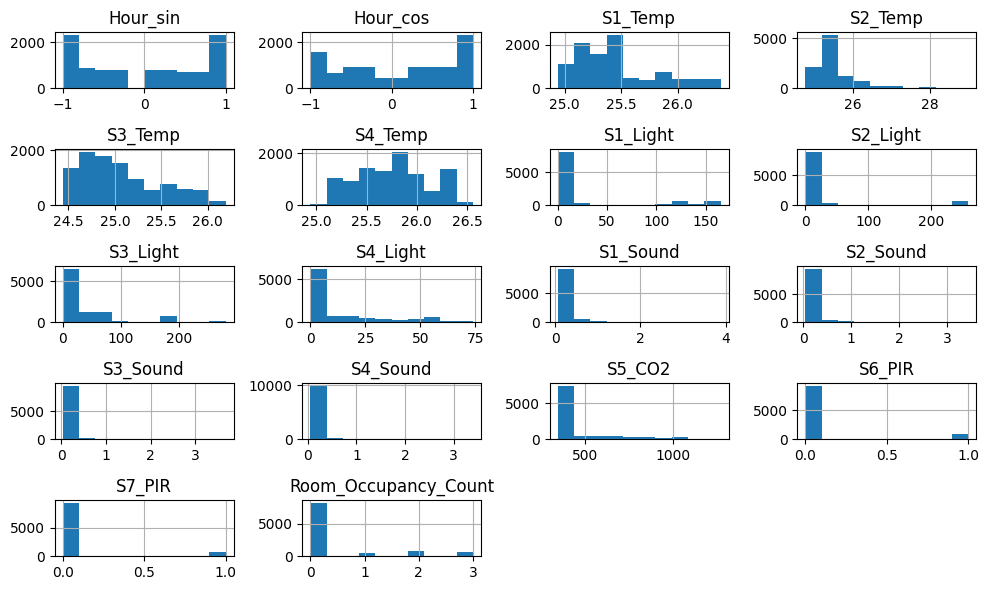

In [266]:
data.hist(bins=10, figsize=(10, 6))
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

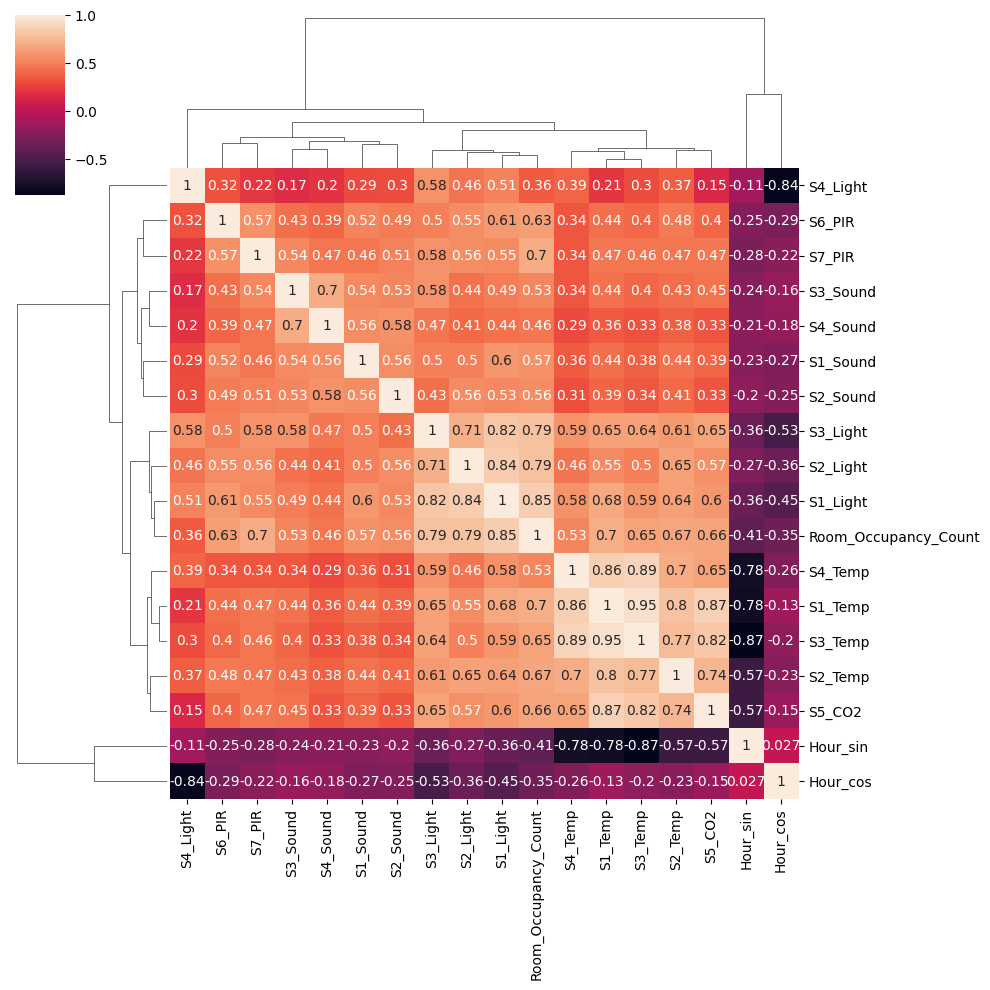

In [267]:
plt.figure(figsize = (10,10))
sns.clustermap(data.corr(), annot = True)

  We will shuffle the data and seperate the labels and the features. Also, will create a training set and a test set.

In [268]:
data = data.sample(frac = 1)

ratio = 0.80

total_rows = data.shape[0]
train_size = int(total_rows*ratio)

train = data[0:train_size]
test = data[train_size:]

X_train = train.drop('Room_Occupancy_Count', axis = 1)
Y_train = train['Room_Occupancy_Count']

X_test = test.drop('Room_Occupancy_Count', axis = 1)
Y_test = test['Room_Occupancy_Count']

print("Training Features:")
print(X_train.describe)
print("\nTest Features:")
print(X_test.describe)

Training Features:
<bound method NDFrame.describe of       Hour_sin      Hour_cos  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light  \
2097  0.965926  2.588190e-01    25.13    25.13    24.56    25.38         0   
4701  0.707107  7.071068e-01    25.25    25.31    24.69    25.63         0   
3657 -1.000000 -1.836970e-16    26.25    26.25    26.00    26.31       113   
5358  0.707107 -7.071068e-01    25.06    25.06    24.63    25.38         8   
3665 -0.965926  2.588190e-01    26.25    26.25    25.94    26.31       114   
...        ...           ...      ...      ...      ...      ...       ...   
3703 -0.965926  2.588190e-01    26.25    26.13    25.94    26.31       114   
9659  0.866025  5.000000e-01    25.13    25.13    24.63    25.25         0   
9959  0.965926 -2.588190e-01    25.06    25.06    24.50    25.19         1   
5517  0.258819 -9.659258e-01    25.13    25.13    24.81    25.69        13   
3112 -0.500000 -8.660254e-01    26.06    27.13    25.50    26.38        14   

      S2_L

# Initialization:
We are going to initialize the weights, bias, activation functions and their derivatives for back propagation.

In [269]:
def initialize(N): # Weights have -0.01 : 0.01 uniform dist.
    W1 = np.random.uniform(-0.01, 0.01, (N, 17))
    b1 = np.random.uniform(-0.01, 0.01, (N, 1))
    W2 = np.random.uniform(-0.01, 0.01, (4, N))
    b2 = np.random.uniform(-0.01, 0.01, (4, 1))
    return W1, b1, W2, b2

def RELU(v):
    return np.maximum(0, v)

def d_RELU(v):
    return v>0

def sigmoid(v):
    return 1/(1+np.exp(-v))

def d_sigmoid(v):
    return sigmoid(v) * (1 - sigmoid(v))

# y will have 1 for true class, and 0 for others
def one_zero(y):
    one_zero_y = np.zeros((y.size, y.max() + 1))
    one_zero_y[np.arange(y.size), y] = 1 # each row of the zeroes vector which corresponds to classified number will become 1
    # for example: if classification = 2, 2nd elementh of zeroes vector will become 1
    one_zero_y = one_zero_y.T
    return one_zero_y

In [270]:
def forward_propagation(W1, b1, W2, b2, X):

    v1 = W1.dot(X)+b1

    o1 = RELU(v1)

    v2 = W2.dot(o1)+b2

    o2 = sigmoid(v2)

    return v1, o1, v2, o2


In [271]:
def back_propagation(v1, o1, v2, o2, W1, W2, x, y, lambda_v):
    m = y.size


    E = np.sum((o2 - one_zero(y)) ** 2) + (lambda_v / 2) * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
    Eave = np.sum(E) / m

    # Regularized term for the gradients
    reg_term_W2 = lambda_v * W2
    reg_term_W1 = lambda_v * W1

    # error for output layer
    e2 = o2 - one_zero(y)
    # Gradient for Output Layer with L2 regularization term
    dW2 = (1/m) * (e2.dot(o1.T)) + reg_term_W2
    db2 = (1/m) * np.sum(e2, axis=1).reshape(-1,1)

    # error for hidden layer
    e1 = (W2.T.dot(e2)) * d_RELU(v1)
    # Gradient for Hidden Layer with L2 regularization term
    dW1 = (1/m) * (e1.dot(x.T)) + reg_term_W1
    db1 = (1/m) * np.sum(e1, axis=1).reshape(-1,1)

    return dW1, db1, dW2, db2, E, Eave

In [272]:
def update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, l_rate):
    W1 = W1 - l_rate*dW1
    b1 = b1 - l_rate*db1
    W2 = W2 - l_rate*dW2
    b2 = b2 - l_rate*db2

    return W1, b1, W2, b2

In [273]:
# Functions for getting results after training is complete
# Find the average succes rate
def accuracy(predictions, y):
    return np.sum(predictions == y) / y.size

# For passing test data with found W1, W2, b1 and b2
def pass_data(X, W1, b1, W2, b2):
    v1, o1, v2, o2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = np.argmax(o2, 0)
    return predictions

In [274]:
# Main function, combine all algorithms
def neural_network(x, y, epochs, l_rate, N, lambda_v):
    W1, b1, W2, b2 = initialize(N) # Initialize weights and biases
    start_time = time.time() # Calculate time for all epochs to end

    for i in range(epochs): #in each epoch
        v1, o1, v2, o2 = forward_propagation(W1, b1, W2, b2, x) # Pass the data through weights to find v's and o's
        dW1, db1, dW2, db2, E, Eave = back_propagation(v1, o1, v2, o2, W1, W2, x, y, lambda_v) # find gradients of weights for 2 layers
        W1, b1, W2, b2 = update_weights(W1, b1, W2, b2, dW1, db1, dW2, db2, l_rate) # update weights

        if i % 10 == 0: # Show accuarcy for per 10 epochs
            print("---------")
            print("Epoch: ", i)
            print("Training Set Success Rate:", accuracy(np.argmax(o2, 0), y))
            print("Mean Square Error:", Eave)

    end_time = time.time()


    # End results for the neural network model
    print("---------")
    print("Number of Epochs:", epochs)
    print("Time:", end_time - start_time, "seconds\n")
    print("Mean Square Error:", Eave)
    print("Training Set Success Rate:", accuracy(np.argmax(o2, 0), y))
    print("Test Set Success Rate:", accuracy(pass_data(X_test.T, W1, b1, W2, b2), Y_test.T))
    print("Test Set Error:", 1- accuracy(pass_data(X_test.T, W1, b1, W2, b2), Y_test.T))

    return W1, b1, W2, b2

Function: Neural Network

Inputs: (x, y, number of epochs, learning rate, hidden layer, neuron number, N, lambda_v)

In [275]:
W1, b1, W2, b2 = neural_network(X_train.T, Y_train.T, 3000, 0.001, 500, 0)

---------
Epoch:  0
Training Set Success Rate: 0.7820560286313711
Mean Square Error: 0.9220519654577414
---------
Epoch:  10
Training Set Success Rate: 0.8138960878686906
Mean Square Error: 0.3563013472866388
---------
Epoch:  20
Training Set Success Rate: 0.816117487350364
Mean Square Error: 0.2946790686523615
---------
Epoch:  30
Training Set Success Rate: 0.8389485375786746
Mean Square Error: 0.2486445030266341
---------
Epoch:  40
Training Set Success Rate: 0.8524003455510305
Mean Square Error: 0.21944629050225797
---------
Epoch:  50
Training Set Success Rate: 0.8669628532642232
Mean Square Error: 0.20257714034821805
---------
Epoch:  60
Training Set Success Rate: 0.883006293965198
Mean Square Error: 0.1918247011399349
---------
Epoch:  70
Training Set Success Rate: 0.8883129705047513
Mean Square Error: 0.18379361059601537
---------
Epoch:  80
Training Set Success Rate: 0.8981858570899667
Mean Square Error: 0.17703744742392016
---------
Epoch:  90
Training Set Success Rate: 0.9009

In [276]:
def test_prediction(index, W1, b1, W2, b2):

    prediction = pass_data(X_train.T, W1, b1, W2, b2)[index]
    label = Y_train.T.iloc[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    print("--------")

"""
for i in range(6000):
  test_prediction(i, W1, b1, W2, b2)
"""
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)
test_prediction(4, W1, b1, W2, b2)
test_prediction(5, W1, b1, W2, b2)
test_prediction(6, W1, b1, W2, b2)
test_prediction(7, W1, b1, W2, b2)
test_prediction(8, W1, b1, W2, b2)
test_prediction(9, W1, b1, W2, b2)
test_prediction(10, W1, b1, W2, b2)
test_prediction(11, W1, b1, W2, b2)
test_prediction(197, W1, b1, W2, b2)

Prediction:  0
Label:  0
--------
Prediction:  0
Label:  0
--------
Prediction:  2
Label:  2
--------
Prediction:  0
Label:  0
--------
Prediction:  2
Label:  2
--------
Prediction:  0
Label:  0
--------
Prediction:  2
Label:  2
--------
Prediction:  0
Label:  0
--------
Prediction:  0
Label:  0
--------
Prediction:  0
Label:  0
--------
Prediction:  0
Label:  0
--------
Prediction:  0
Label:  0
--------
Prediction:  1
Label:  1
--------
